In [1]:
# Importing necessary libraries
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf
from tensorflow.keras import layers, models
import pathlib
import matplotlib.pyplot as plt

/kaggle/input/guava-disease-dataset/dataset_summary.csv
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/72_unsharp_clahe_augmented_6.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/49_unsharp_clahe_augmented_1.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/57_unsharp_clahe_augmented_1.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/97_unsharp_clahe_augmented_3.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/60_unsharp_clahe_augmented_4.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/100_unsharp_clahe_augmented_3.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava/26_unsharp_clahe_augmented_1.png
/kaggle/input/guava-disease-dataset/GuavaDiseaseDatase

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(123)

In [3]:
# Define the path to the dataset
data = pathlib.Path("/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/train")

# Define batch size and image size
batch_size = 32
img_height = 180
img_width = 180

# Load the dataset with a validation split
train_data = tf.keras.utils.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="int", 
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    validation_split=0.2, 
    subset="training",
    seed=123
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Check class names
class_names = train_data.class_names
print("Class names:", class_names)

Found 2647 files belonging to 3 classes.
Using 2118 files for training.
Found 2647 files belonging to 3 classes.
Using 529 files for validation.
Class names: ['Anthracnose', 'fruit_fly', 'healthy_guava']


# Visualization images

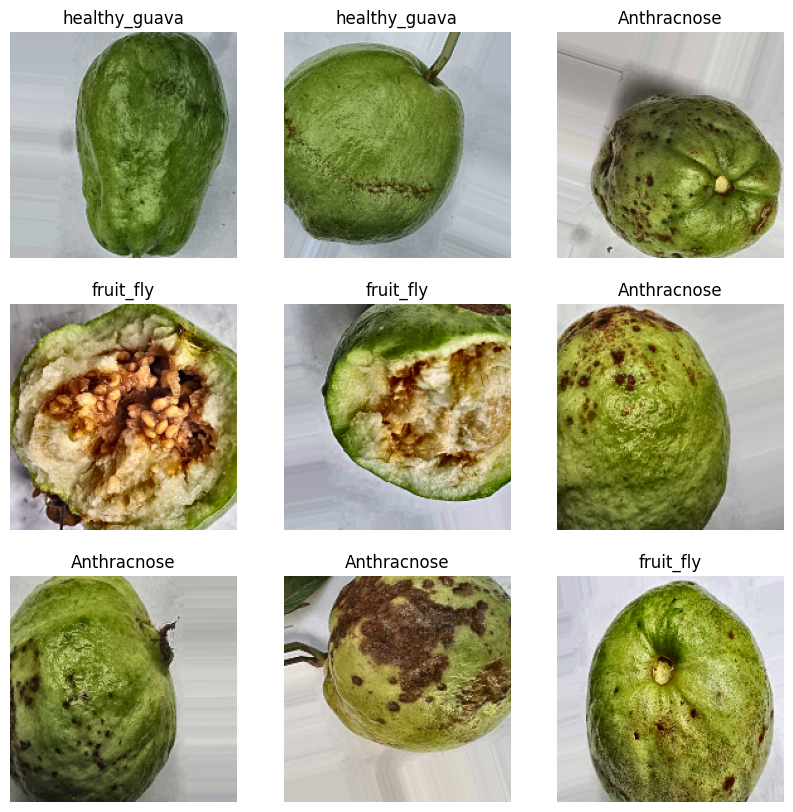

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Configure Dataset

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Define a function to create a CNN model
def create_model(model_type='basic'):
    model = models.Sequential()
    
    # Preprocessing layer
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    
    if model_type == 'basic':
        # Basic CNN Model
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        
    elif model_type == 'dropout':
        # CNN with Dropout for regularization
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(0.5))  # Added dropout layer
        
    elif model_type == 'transfer_learning':
        # Transfer Learning with a pre-trained model (e.g., MobileNetV2)
        base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                                       include_top=False,
                                                       weights='imagenet')
        base_model.trainable = False  # Freeze the base model
        
        model.add(base_model)
    
    # Common layers after feature extraction
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(class_names), activation='softmax'))
    
    return model

# CNN Model

In [7]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,451 (5.98 MB)

 Trainable params: 1,568,451 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Model

In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model

In [9]:
epochs = 10  # Set number of epochs as needed
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.3728 - loss: 1.0831 - val_accuracy: 0.5898 - val_loss: 0.7686
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6321 - loss: 0.7179 - val_accuracy: 0.7467 - val_loss: 0.5442
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7953 - loss: 0.4873 - val_accuracy: 0.8979 - val_loss: 0.2828
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9029 - loss: 0.2818 - val_accuracy: 0.9301 - val_loss: 0.1783
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9184 - loss: 0.2264 - val_accuracy: 0.9301 - val_loss: 0.1630
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9155 - loss: 0.2260 - val_accuracy: 0.9338 - val_loss: 0.1564
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9436 - loss: 0.1571 - val_accuracy: 0.9319 - val_loss: 0.1748
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9625 - loss: 0.0990 - val_accuracy: 0.9376 - val_loss:

# Plot Training and Validation Accuracy

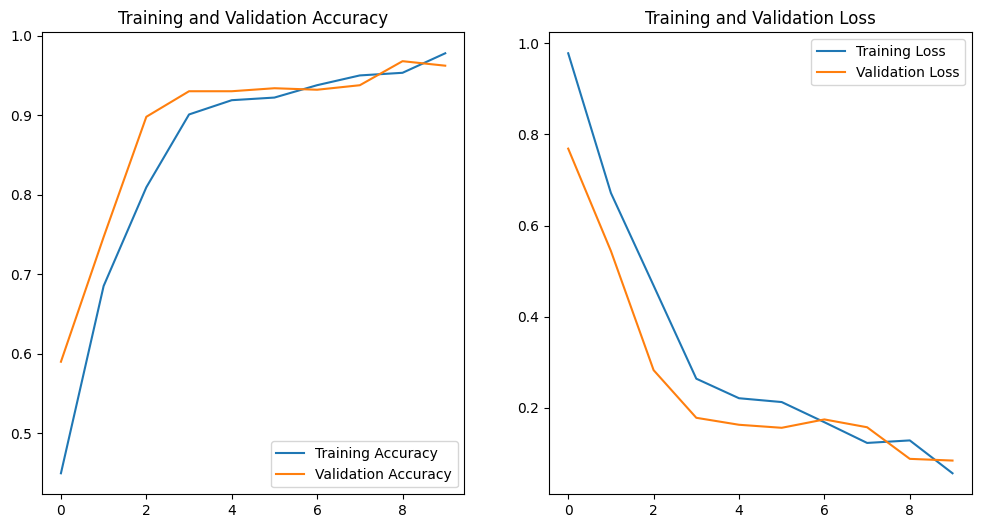

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the Model

In [11]:
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9556 - loss: 0.1202
Validation Loss: 0.08455222100019455
Validation Accuracy: 0.9621928334236145


# Save the model

In [12]:
model.save('guava_disease_classifier_model.h5')